In [1]:
from mplsoccer import Pitch, VerticalPitch, Standardizer
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
import matplotlib as mpl
from splink.duckdb.duckdb_linker import DuckDBLinker
from splink.duckdb.duckdb_comparison_library import levenshtein_at_thresholds
%config InlineBackend.figure_format='retina'

In [2]:
WYSCOUT = os.path.join('..', 'data', 'wyscout')
STATSBOMB = os.path.join('..', 'data', 'statsbomb')

Load data

In [3]:
df_wyscout_event = pd.read_parquet(os.path.join(WYSCOUT, 'event_overlap.parquet'))
df_statsbomb_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_wyscout_match = pd.read_parquet(os.path.join(WYSCOUT, 'match.parquet'))
df_wyscout_match_overlap = pd.read_parquet(os.path.join(WYSCOUT, 'match_overlap.parquet'))
df_wyscout_player = pd.read_parquet(os.path.join(WYSCOUT, 'player.parquet'))
df_statsbomb_match = pd.read_parquet(os.path.join(STATSBOMB, 'match.parquet'))
df_statsbomb_tactic = pd.read_parquet(os.path.join(STATSBOMB, 'tactic.parquet'))
df_statsbomb_lineup = pd.read_parquet(os.path.join(STATSBOMB, 'lineup.parquet'))

Number of passes for starting players from StatsBomb data

In [4]:
#df_start = df_statsbomb_event.loc[df_statsbomb_event.type_name=='Starting XI', ['id']]
#df_start = df_start.merge(df_statsbomb_tactic, how='left')
#df_start = df_start[['match_id', 'player_id']]
#df_pass = df_statsbomb_event[df_statsbomb_event.type_name == 'Pass'].copy()
#df_pass_start = df_start.merge(df_pass, on=['match_id', 'player_id'], how='inner')
#df_pass_start.groupby(['match_id','player_id']).type_name.count().mean()
# 42.326760995045206

Games per competition

In [5]:
df_statsbomb_match.competition_name.value_counts()

La Liga                    520
FA Women's Super League    326
Indian Super league        115
FIFA World Cup              64
Women's World Cup           52
UEFA Euro                   51
NWSL                        36
Premier League              33
UEFA Women's Euro           31
Champions League            14
Name: competition_name, dtype: int64

In [6]:
df_statsbomb_match.groupby(['competition_name', 'season_name']).match_id.count()

competition_name         season_name
Champions League         2003/2004        1
                         2004/2005        1
                         2006/2007        1
                         2008/2009        1
                         2009/2010        1
                         2010/2011        1
                         2011/2012        1
                         2012/2013        1
                         2013/2014        1
                         2014/2015        1
                         2015/2016        1
                         2016/2017        1
                         2017/2018        1
                         2018/2019        1
FA Women's Super League  2018/2019      108
                         2019/2020       87
                         2020/2021      131
FIFA World Cup           2018            64
Indian Super league      2021/2022      115
La Liga                  2004/2005        7
                         2005/2006       17
                         2006/2007     

% Shots belonging to Barcelona 

In [7]:
num_barca_shots = ((df_statsbomb_event.team_name=='Barcelona') & (df_statsbomb_event.type_name=='Shot')).sum()
num_total_shots = (df_statsbomb_event.type_name=='Shot').sum()
print('Proportion of shots taken by Barcelona in StatsBomb data:', round(num_barca_shots/num_total_shots * 100, 1))

Proportion of shots taken by Barcelona in StatsBomb data: 25.8


Number shots relating to Messi

In [8]:
num_messi_shots = ((df_statsbomb_event.player_name == 'Lionel Andrés Messi Cuccittini') &
                   (df_statsbomb_event.type_name=='Shot')).sum()

In [9]:
print('Number of Messi shots in the StatsBomb dataset', num_messi_shots)
print('Number of total shots in the StatsBomb dataset', num_total_shots)

Number of Messi shots in the StatsBomb dataset 2385
Number of total shots in the StatsBomb dataset 31992


Combine wyscout match

In [10]:
df_wyscout_match = pd.concat([df_wyscout_match, df_wyscout_match_overlap])

Games in the Wyscout data

In [11]:
print(len(df_wyscout_match))

1941


In [12]:
df_wyscout_match.groupby(['season_name', 'competition_name']).season_name.count()

season_name  competition_name
2016         UEFA Euro            51
2017/2018    Bundesliga          306
             La Liga             380
             Ligue 1             380
             Premier League      380
             Serie A             380
2018         FIFA World Cup       64
Name: season_name, dtype: int64

In [13]:
df_statsbomb_shots = df_statsbomb_event[(df_statsbomb_event.type_name=='Shot')&
                                        (df_statsbomb_event.sub_type_name!='Penalty')].dropna(how='all', axis=1).copy()
df_wyscout_shots = df_wyscout_event[((df_wyscout_event.eventName=='Shot')|
                                    (df_wyscout_event.subEventName=='Free kick shot')) &
                                    (df_wyscout_event['matchPeriod']!='P')].copy()

Subset StatsBomb overlap

In [14]:
mask_sb_overlap = ((df_statsbomb_match.competition_name == 'FIFA World Cup')|
                   ((df_statsbomb_match.competition_name == 'La Liga') & (df_statsbomb_match.season_name == '2017/2018')))
overlap_id = df_statsbomb_match.loc[mask_sb_overlap, 'match_id']
df_statsbomb_event = df_statsbomb_event[df_statsbomb_event.match_id.isin(overlap_id)].copy()

Number of non-penalty shots in the Wyscout data

In [15]:
mask_shot_wy = (((df_wyscout_event.eventName=='Shot') | (df_wyscout_event.subEventName=='Free kick shot')) & 
                (df_wyscout_event['matchPeriod']!='P'))
print('Number of non-penalty shots:', mask_shot_wy.sum())

Number of non-penalty shots: 2420


Number of no-penalty shots in the StatsBomb data

In [16]:
mask_shot_sb = (df_statsbomb_event.type_name == 'Shot') & (df_statsbomb_event.sub_type_name!='Penalty')
print('Number of non-penalty shots - StatsBomb:', mask_shot_sb.sum())

Number of non-penalty shots - StatsBomb: 2600


Add match_id from other dataset

In [17]:
df_id1 = df_wyscout_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']].copy()
df_id2 = df_statsbomb_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']].copy()
df_id1['kick_off'] = pd.to_datetime(df_id1.kick_off.dt.date)
df_id2['kick_off'] = pd.to_datetime(df_id2.kick_off.dt.date)
df_overlap = df_id1.merge(df_id2, on=['home_team_name', 'away_team_name', 'home_score', 'kick_off'], how='inner', 
                          suffixes=['_wyscout', '_statsbomb'])
df_overlap = df_overlap[['match_id_wyscout', 'match_id_statsbomb']]
df_statsbomb_event = df_statsbomb_event.merge(df_overlap, left_on='match_id', right_on='match_id_statsbomb', how='left')
df_wyscout_event = df_wyscout_event.merge(df_overlap, left_on='match_id', right_on='match_id_wyscout', how='left')

Add team name to Wyscout

In [18]:
df_team1 = df_wyscout_match[['home_team_id', 'home_team_name']].copy()
df_team1.rename({'home_team_id': 'team_id','home_team_name': 'team_name'}, axis=1, inplace=True)
df_team2 = df_wyscout_match[['away_team_id', 'away_team_name']].copy()
df_team2.rename({'away_team_id': 'team_id','away_team_name': 'team_name'}, axis=1, inplace=True)
df_teams = pd.concat([df_team1, df_team2]).drop_duplicates()
df_wyscout_event = df_wyscout_event.merge(df_teams, on='team_id', how='left')

Add player name to Wyscout. I am going to seperate out the last part of the name, the first part of the name and anything inbetween. This may not be technically accurate, but it's easier to join

In [19]:
df_wyscout_player['fullName'] = (df_wyscout_player.firstName + ' ' + df_wyscout_player.lastName).str.strip()
player_name_series = df_wyscout_player.fullName.str.split(' ')
df_wyscout_player['firstName'] = player_name_series.apply(lambda x: x[0] if isinstance(x, list) else None)
df_wyscout_player['middleName'] = player_name_series.apply(lambda x: ' '.join(x[1:-1]) if isinstance(x, list) else None)
df_wyscout_player['lastName'] = player_name_series.apply(lambda x: x[-1] if isinstance(x, list) else None)
df_wyscout_player['middleName'] = df_wyscout_player['middleName'].str.strip()
df_wyscout_player['Name'] = ((df_wyscout_player['firstName'] + ' ' + df_wyscout_player['middleName']).str.strip()
                             + ' ' + df_wyscout_player['lastName'])
df_wyscout_event = df_wyscout_event.merge(df_wyscout_player, how='left')

Add player name to StatsBomb

In [20]:
player_name_series = df_statsbomb_event.player_name.str.strip().str.replace(pat='"', repl="'").str.split(' ')
df_statsbomb_event['firstName'] = player_name_series.apply(lambda x: x[0] if isinstance(x, list) else None)
df_statsbomb_event['middleName'] = player_name_series.apply(lambda x: ' '.join(x[1:-1]) if isinstance(x, list) else None)
df_statsbomb_event['middleName'] = df_statsbomb_event['middleName'].str.strip()
df_statsbomb_event['lastName'] = player_name_series.apply(lambda x: x[-1] if isinstance(x, list) else None)
df_statsbomb_event['Name'] = ((df_statsbomb_event['firstName'] + ' ' + df_statsbomb_event['middleName']).str.strip()
                              + ' ' + df_statsbomb_event['lastName'])

Subset non-penalty shots

In [21]:
df_statsbomb_shots = df_statsbomb_event[(df_statsbomb_event.type_name=='Shot')&
                                        (df_statsbomb_event.sub_type_name!='Penalty')].dropna(how='all', axis=1).copy()
df_wyscout_shots = df_wyscout_event[((df_wyscout_event.eventName=='Shot')|
                                    (df_wyscout_event.subEventName=='Free kick shot')) &
                                    (df_wyscout_event['matchPeriod']!='P')].copy()

In [22]:
print('Number of StatsBomb shots:', len(df_statsbomb_shots))
print('Number of Wyscout shots:', len(df_wyscout_shots))

Number of StatsBomb shots: 2600
Number of Wyscout shots: 2420


Add consistent seconds (eventSec) in Wyscout

In [23]:
df_statsbomb_shots['eventSec'] = df_statsbomb_shots.timestamp.apply(lambda x: x.minute * 60 + x.second + x.microsecond / 1000000)

Add consistent period (in wyscout it's matchPeriod=1H/2H/E1/E2 in StatsBomb its period=1/2/3/4)

In [24]:
df_wyscout_shots['period'] = df_wyscout_shots['matchPeriod'].replace({'1H': 1, '2H': 2, 'E1': 3, 'E2': 4})

Add on country name

In [25]:
df_wyscout_shots.rename({'birthArea_name': 'country_name'}, axis='columns', inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(df_statsbomb_lineup[['player_id', 'country_name']].drop_duplicates('player_id'),
                                              how='left', on='player_id', validate='m:1')

Create a combined player id

In [26]:
cols = ['player_id', 'team_id', 'team_name', 'firstName', 'middleName', 'lastName', 'Name', 'country_name']
a = (df_wyscout_shots[cols]
     .drop_duplicates('player_id')
     .copy()
    )
a['unique_id'] = 'wyscout' + '-' + a.player_id.astype(str)
a['dataset'] = 'wyscout'
b = (df_statsbomb_shots[cols]
     .drop_duplicates('player_id')
     .copy()
    )
b['unique_id'] = 'statsbomb' + '-' + b.player_id.astype(str)
b['dataset'] = 'statsbomb'
df_duplicates = pd.concat([a, b])

In [27]:
comparison_rules = [
    levenshtein_at_thresholds('firstName', 2),
    levenshtein_at_thresholds('lastName', 2),
    levenshtein_at_thresholds('Name', 2),
    levenshtein_at_thresholds('team_name', 2),
    levenshtein_at_thresholds('country_name', 2),
    ]
settings = {
    'link_type': 'dedupe_only',
    'blocking_rules_to_generate_predictions': [
        'l.firstName = r.firstName',
        'l.lastName = r.lastName',
        'l.team_name = r.team_name',
    ],
    'comparisons': comparison_rules
}
linker = DuckDBLinker(df_duplicates, settings)
linker.estimate_u_using_random_sampling(target_rows=1e6)
linker.estimate_m_from_label_column('firstName')
linker.estimate_m_from_label_column('lastName')
linker.estimate_m_from_label_column('Name')
linker.estimate_m_from_label_column('team_name')
linker.estimate_m_from_label_column('country_name')

pairwise_predictions = linker.predict(threshold_match_probability=0.99)
clusters = linker.cluster_pairwise_predictions_at_threshold(pairwise_predictions, 0.99)
df_clusters = clusters.as_pandas_dataframe()

# where clustered together in same dataset set back to original identifiers
mask_change_cluster = df_clusters.duplicated(['cluster_id', 'dataset'], keep=False)
df_clusters.loc[mask_change_cluster, 'cluster_id'] = df_clusters.loc[mask_change_cluster, 'unique_id']

----- Estimating u probabilities using random sampling -----
u probability not trained for team_name - levenshtein <= 2 (comparison vector value: 1). This usually means the comparison level was never observed in the training data.

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstName (no m values are trained).
    - lastName (no m values are trained).
    - Name (no m values are trained).
    - team_name (some u values are not trained, no m values are trained).
    - country_name (no m values are trained).
------- Estimating m probabilities using from column firstName -------
u probability not trained for firstName - levenshtein <= 2 (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
u probability not trained for firstName - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.


In [28]:
df_cluster_names = df_clusters.drop_duplicates('cluster_id', keep='first')[['cluster_id', 'firstName', 'middleName', 'lastName', 'Name']].copy()

# merge wyscout
df_wyscout_id = df_clusters.loc[df_clusters.dataset == 'wyscout', ['unique_id', 'cluster_id']].copy()
df_wyscout_id['unique_id'] = df_wyscout_id['unique_id'].str.split('-').str[1].astype(float).astype(int)
df_wyscout_id.rename({'unique_id': 'player_id'}, axis='columns', inplace=True)
df_wyscout_shots = (df_wyscout_shots
                    .rename({'player_id_wyscout': 'player_id'}, axis='columns')
                    .merge(df_wyscout_id, on='player_id', how='left', validate='m:1')
                    .rename({'player_id': 'player_id_wyscout'}, axis='columns')
                    .drop([ 'firstName', 'middleName', 'lastName', 'Name'], axis='columns')
                    .merge(df_cluster_names, on='cluster_id', how='left', validate='m:1')
                   )

# merge statsbomb
df_statsbomb_id = df_clusters.loc[df_clusters.dataset == 'statsbomb', ['unique_id', 'cluster_id']].copy()
df_statsbomb_id['unique_id'] = df_statsbomb_id['unique_id'].str.split('-').str[1].astype(float).astype(int)
df_statsbomb_id.rename({'unique_id': 'player_id'}, axis='columns', inplace=True)
df_statsbomb_shots = (df_statsbomb_shots
                      .rename({'player_id_statsbomb': 'player_id'}, axis='columns')
                      .merge(df_statsbomb_id, on='player_id', how='left', validate='m:1')
                      .rename({'player_id': 'player_id_statsbomb'}, axis='columns')
                      .drop([ 'firstName', 'middleName', 'lastName', 'Name'], axis='columns')
                      .merge(df_cluster_names, on='cluster_id', how='left', validate='m:1')
                     )

In [29]:
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_shots))
print('Number of Wyscout shots:', len(df_wyscout_shots))

Number of StatsBomb shots: 2600
Number of Wyscout shots: 2420


Add metadata

In [30]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_statsbomb_match[['match_id', 'metadata_shot_fidelity_version']],
                                              on='match_id', how='left', validate='m:1')

@lemonwatcher says:

1) coordinates denote the bottom-right corner of a cell in a grid, not an actual point, so 1,1 is the top-left square 'yard' of the field (in landscape), even though 0,0 is the true coordinate of the corner flag.

2) some matches have metadata like "xy_fidelity_version" : "2", which means the grid has higher granularity. In this case 0.1,0.1 is the top left cell. We appear to have elided this bit of the docs in the repo, which I will attempt to remedy.

So here we set to the middle of the grid

In [31]:
mask_fidelity = df_statsbomb_shots.metadata_shot_fidelity_version!='2'
df_statsbomb_shots.loc[mask_fidelity, 'x'] = df_statsbomb_shots.loc[mask_fidelity, 'x'] - 0.5
df_statsbomb_shots.loc[mask_fidelity, 'y'] = df_statsbomb_shots.loc[mask_fidelity, 'y'] - 0.5
mask_fidelity = df_statsbomb_shots.metadata_shot_fidelity_version=='2'
df_statsbomb_shots.loc[mask_fidelity, 'x'] = df_statsbomb_shots.loc[mask_fidelity, 'x'] - 0.05
df_statsbomb_shots.loc[mask_fidelity, 'y'] = df_statsbomb_shots.loc[mask_fidelity, 'y'] - 0.05

Standardise to the same coordinate system 105*68

In [32]:
# statsbomb
standard = Standardizer(pitch_to='uefa', pitch_from='statsbomb')
new_x, new_y = standard.transform(df_statsbomb_shots.x, df_statsbomb_shots.y)
df_statsbomb_shots['x'] = new_x
df_statsbomb_shots['y'] = new_y
new_end_x, new_end_y = standard.transform(df_statsbomb_shots.end_x, df_statsbomb_shots.end_y)
df_statsbomb_shots['end_x'] = new_end_x
df_statsbomb_shots['end_y'] = new_end_y

# wyscout
standard = Standardizer(pitch_to='uefa', pitch_from='wyscout')
new_x, new_y = standard.transform(df_wyscout_shots.x, df_wyscout_shots.y)
df_wyscout_shots['x'] = new_x
df_wyscout_shots['y'] = new_y
new_end_x, new_end_y = standard.transform(df_wyscout_shots.end_x, df_wyscout_shots.end_y)
df_wyscout_shots['end_x'] = new_end_x
df_wyscout_shots['end_y'] = new_end_y

Subset interesting variables

In [33]:
df_statsbomb_shots = df_statsbomb_shots[['id', 'match_id_wyscout', 'cluster_id', 'eventSec', 'period',
                                         'sub_type_name', 'technique_name', 'team_name', 'Name',
                                         'x', 'y', 'end_x', 'end_y', 'end_z',
                                         'body_part_name', 'outcome_name']].copy()

In [34]:
df_wyscout_shots = df_wyscout_shots[['id', 'match_id_wyscout', 'cluster_id', 'eventSec', 'period',
                                     'team_name', 'Name', 'x', 'y', 'end_x', 'end_y', 'left_foot', 
                                     'right_foot', 'head_body', 'goal']].copy()

Merge shots

In [35]:
# sort the dataframe as needed for a merge_asof
df_statsbomb_shots.sort_values('eventSec', inplace=True)
df_wyscout_shots.sort_values('eventSec', inplace=True)
# copy the time column for working out time difference
df_statsbomb_shots['eventSec_statsbomb'] = df_statsbomb_shots.eventSec
df_wyscout_shots['eventSec_wyscout'] = df_wyscout_shots.eventSec
# match to closest shot by time - allow up to 20 second difference
df_statsbomb_shots_merged = pd.merge_asof(df_statsbomb_shots, df_wyscout_shots, on='eventSec', 
                                          by=['match_id_wyscout', 'cluster_id', 'period'],
                                          suffixes=('_statsbomb', '_wyscout'),
                                          tolerance=26, direction='nearest')
matched_shots = df_statsbomb_shots_merged[df_statsbomb_shots_merged.id_wyscout.notnull()].copy()
unmatched_shots = df_statsbomb_shots_merged[df_statsbomb_shots_merged.id_wyscout.isnull()].copy()
# where statsbomb shot matched to multiple wyscout shots deduplicate
matched_shots['time_diff'] = (abs(matched_shots['eventSec_statsbomb'] - matched_shots['eventSec_wyscout']))
matched_shots.sort_values('time_diff', inplace=True)
matched_shots_dedup = matched_shots.drop_duplicates('id_wyscout', keep='first')
# get the real matches, i.e. the first match for a shot
mask_real_match = matched_shots.id_statsbomb.isin(matched_shots_dedup.id_statsbomb)
df_matched_shots = matched_shots[mask_real_match].copy()  # collect matched shots
# get the unmatched shots
df_wyscout_unmatched = df_wyscout_shots[~df_wyscout_shots.id.isin(df_matched_shots.id_wyscout)].copy()
df_statsbomb_unmatched = df_statsbomb_shots[~df_statsbomb_shots.id.isin(df_matched_shots.id_statsbomb)].copy()
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_unmatched) + len(df_matched_shots))
print('Number of Wyscout shots:', len(df_wyscout_unmatched) + len(df_matched_shots))

Number of StatsBomb shots: 2600
Number of Wyscout shots: 2420


Second merge to catch a few more

In [36]:
match_second = pd.merge_asof(df_statsbomb_unmatched, df_wyscout_unmatched, on='eventSec', 
                             by=['match_id_wyscout', 'cluster_id', 'period'],
                             suffixes=('_statsbomb', '_wyscout'),
                             tolerance=26, direction='nearest')
df_matched_shots = pd.concat([df_matched_shots, match_second[match_second.id_wyscout.notnull()]])
df_wyscout_unmatched = df_wyscout_unmatched[~df_wyscout_unmatched.id.isin(df_matched_shots.id_wyscout)]
df_statsbomb_unmatched = df_statsbomb_unmatched[~df_statsbomb_unmatched.id.isin(df_matched_shots.id_statsbomb)]
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_unmatched) + len(df_matched_shots))
print('Number of Wyscout shots:', len(df_wyscout_unmatched) + len(df_matched_shots))

Number of StatsBomb shots: 2600
Number of Wyscout shots: 2420


In [37]:
print('Number of matched shots:', len(df_matched_shots))
print('Number of unmatched Wyscout shots:', len(df_wyscout_unmatched))
print('Number of unmatched StatsBomb shots:', len(df_statsbomb_unmatched))

Number of matched shots: 2346
Number of unmatched Wyscout shots: 74
Number of unmatched StatsBomb shots: 254


Plot unmatched shots

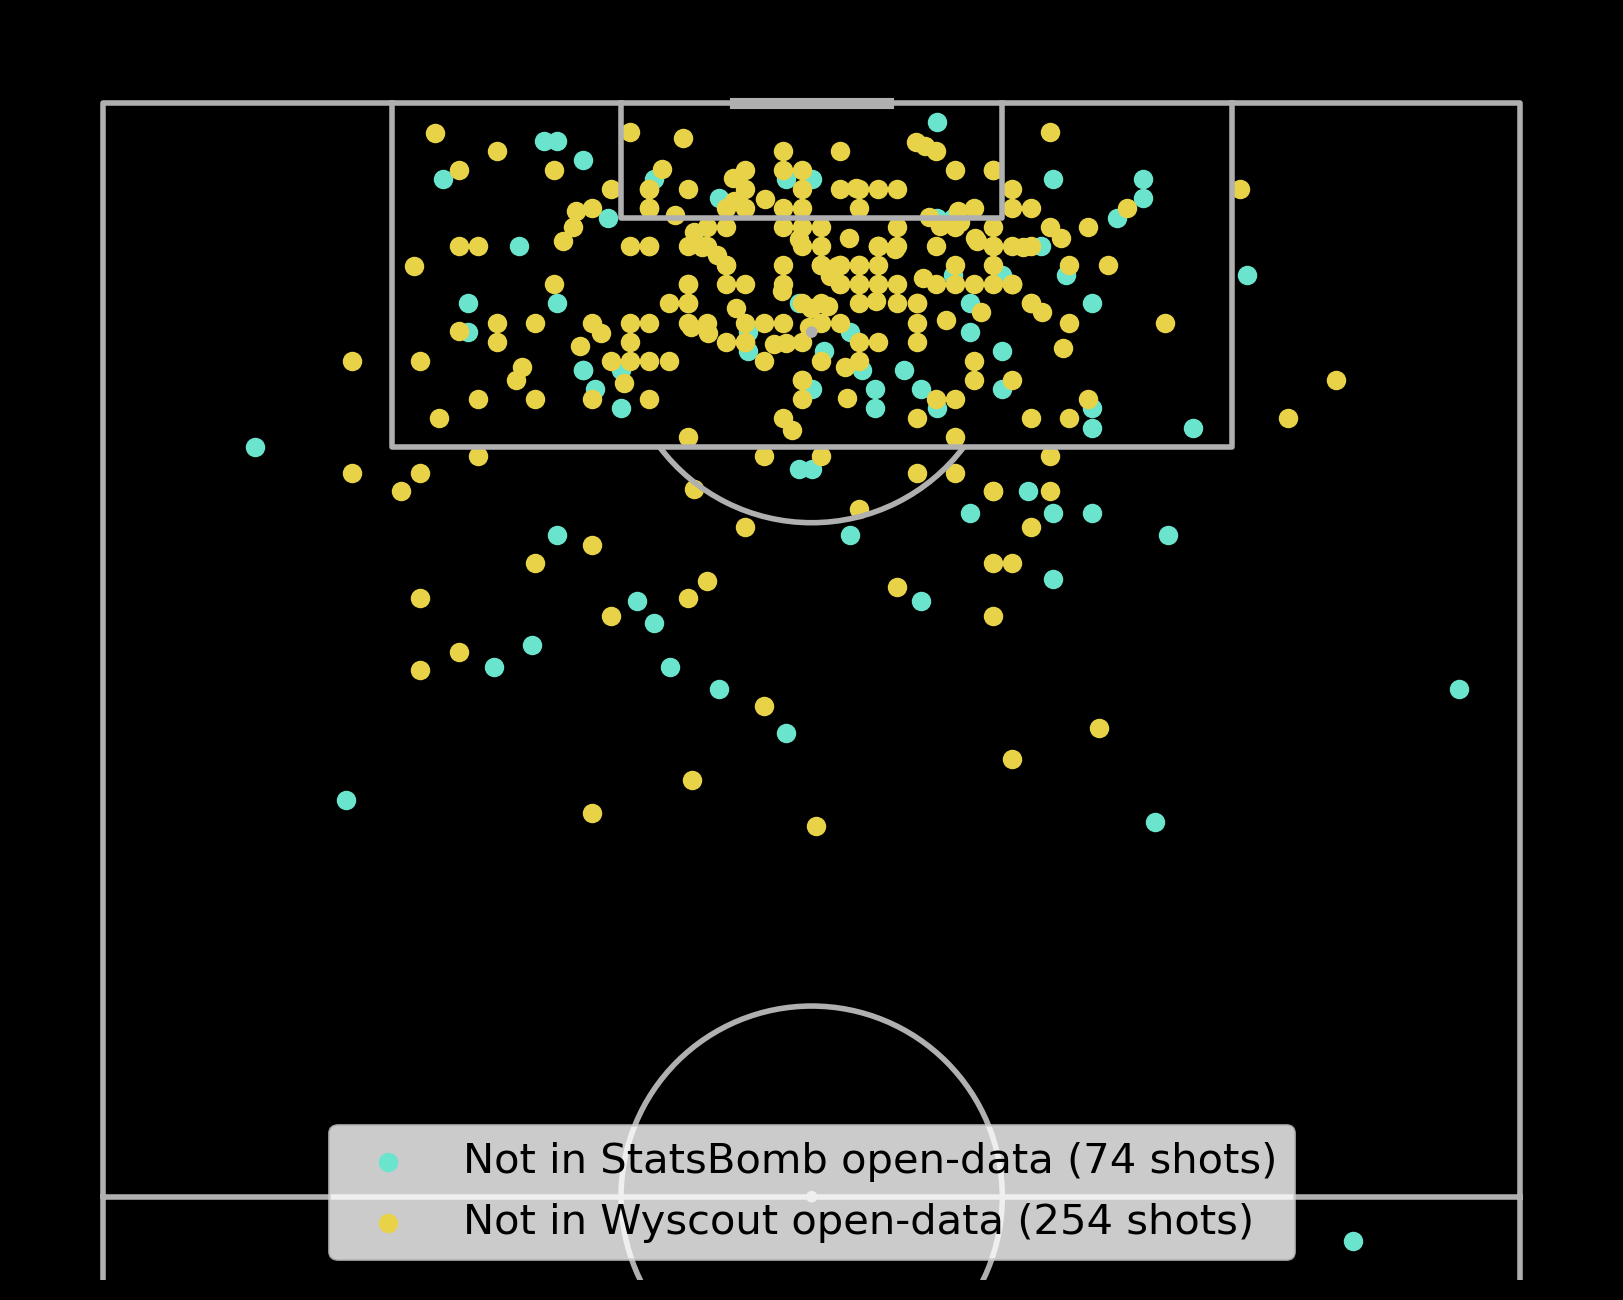

In [38]:
pitch = VerticalPitch(pitch_type='uefa', half=True, pitch_color='black', line_zorder=3)
fig, ax = pitch.draw(figsize=(8, 9), constrained_layout=True, tight_layout=False)
pitch.scatter(df_wyscout_unmatched.x, df_wyscout_unmatched.y, ax=ax, c='#6ae4cd',
              label=f'Not in StatsBomb open-data ({len(df_wyscout_unmatched)} shots)')
pitch.scatter(df_statsbomb_unmatched.x, df_statsbomb_unmatched.y, ax=ax, c='#e8d247',
              label=f'Not in Wyscout open-data ({len(df_statsbomb_unmatched)} shots)')
ax.legend(fontsize=15, loc='lower center')
fig.set_facecolor('black')
fig.savefig(os.path.join('..', 'figures', '12_overlap_shot_differences.png'),
            bbox_inches = 'tight', pad_inches = 0.2, facecolor='black')

Plot difference

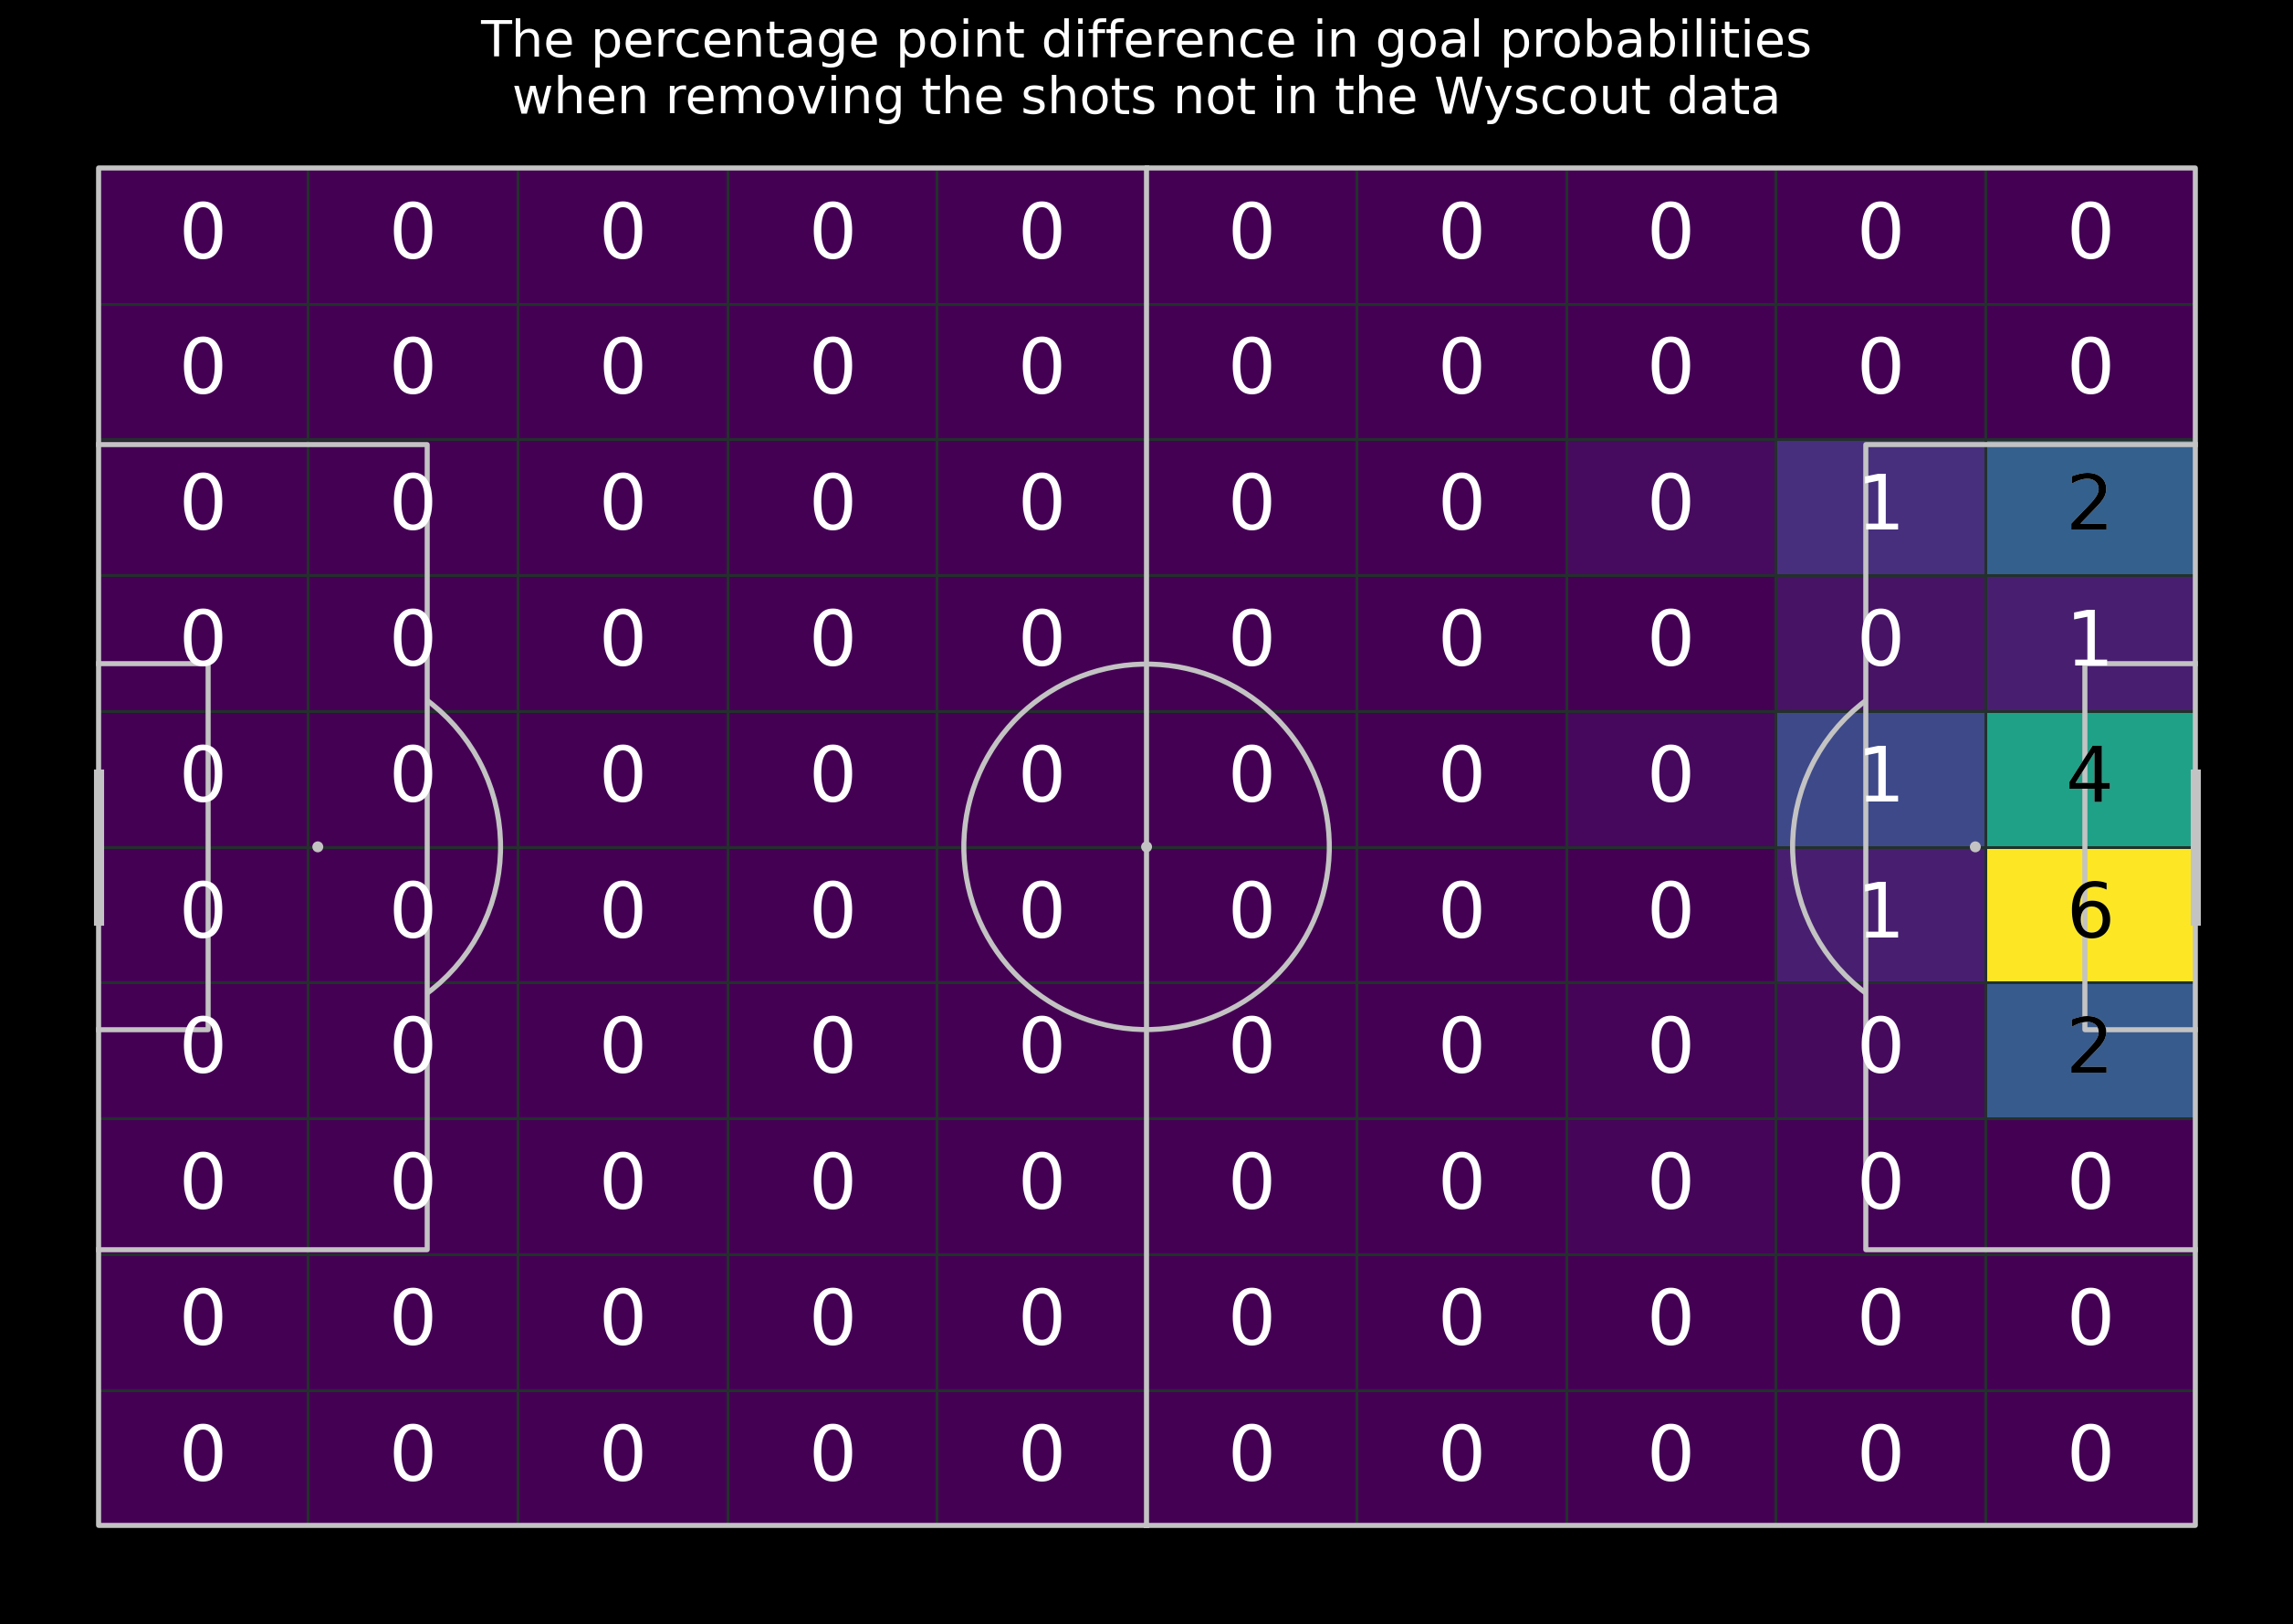

In [39]:
# goal probabilities for all shots
pitch = Pitch(pitch_type='uefa', line_zorder=3, pad_top=2,
              pitch_color='black', line_color='#C3C3C3')
mask_goal = df_statsbomb_shots.outcome_name == 'Goal'
bin_statistic_sb = pitch.bin_statistic(df_statsbomb_shots.x,
                                       df_statsbomb_shots.y,
                                       mask_goal,
                                       statistic='mean',
                                       bins=(5, 5))
# goal probabilities for matched shots
mask_goal = df_matched_shots.outcome_name == 'Goal'
bin_statistic_match = pitch.bin_statistic(df_matched_shots.x_statsbomb,
                                          df_matched_shots.y_statsbomb,
                                          mask_goal,
                                          statistic='mean',
                                          bins=(5, 5))
# goal probabilities for all shots
mask_goal = df_statsbomb_shots.outcome_name == 'Goal'
bin_statistic_sb = pitch.bin_statistic(df_statsbomb_shots.x,
                                       df_statsbomb_shots.y,
                                       mask_goal,
                                       statistic='mean',
                                       bins=(10, 10))
# goal probabilities for matched shots
mask_goal = df_matched_shots.outcome_name == 'Goal'
bin_statistic_match = pitch.bin_statistic(df_matched_shots.x_statsbomb,
                                          df_matched_shots.y_statsbomb,
                                          mask_goal,
                                          statistic='mean',
                                          bins=(10, 10))

# calculate difference, i.e. what would happen if only have wyscout shots
bin_statistic_sb['statistic'] = np.nan_to_num(bin_statistic_match['statistic']) - np.nan_to_num(bin_statistic_sb['statistic'])

fig, ax = pitch.draw(figsize=(16, 9))
pcm = pitch.heatmap(bin_statistic_sb, ax=ax, cmap='viridis', edgecolors='#22312b', zorder=1)
bin_statistic_sb['statistic'] = np.round(bin_statistic_sb['statistic'] * 100., 0).astype(np.int32)
mask = bin_statistic_sb['statistic'] > 1
bin_statistic_sb['statistic'] = bin_statistic_sb['statistic'].astype(str)
label = pitch.label_heatmap(bin_statistic_sb, color='white', fontsize=30, ax=ax, ha='center', va='center')
bin_statistic_sb['statistic'][~mask] = ''
label = pitch.label_heatmap(bin_statistic_sb, color='black', fontsize=30, ax=ax, ha='center', va='center')
ax.set_title('The percentage point difference in goal probabilities\nwhen removing the shots not in the Wyscout data',
             fontsize=20, color='white')
fig.set_facecolor('black')
fig.savefig(os.path.join('..', 'figures', '13_overlap_shot_differences_probabilities.png'),
            bbox_inches = 'tight', facecolor='black', pad_inches = 0.2)

In [40]:
df_statsbomb_unmatched.outcome_name.value_counts()

Wayward    100
Blocked     61
Off T       56
Saved       32
Goal         4
Post         1
Name: outcome_name, dtype: int64

In [41]:
df_statsbomb_unmatched.body_part_name.value_counts() / len(df_statsbomb_unmatched.body_part_name)

Head          0.437008
Right Foot    0.318898
Left Foot     0.224409
Other         0.019685
Name: body_part_name, dtype: float64

In [42]:
df_statsbomb_unmatched[df_statsbomb_unmatched.body_part_name != 'Head'].outcome_name.value_counts()

Wayward    44
Blocked    43
Off T      33
Saved      20
Goal        3
Name: outcome_name, dtype: int64

In [43]:
df_statsbomb_unmatched[df_statsbomb_unmatched.body_part_name == 'Head'].outcome_name.value_counts()

Wayward    56
Off T      23
Blocked    18
Saved      12
Post        1
Goal        1
Name: outcome_name, dtype: int64

In [44]:
wayward = df_statsbomb_unmatched[df_statsbomb_unmatched.outcome_name == 'Wayward']
blocked = df_statsbomb_unmatched[df_statsbomb_unmatched.outcome_name == 'Blocked']
off_target = df_statsbomb_unmatched[df_statsbomb_unmatched.outcome_name == 'Off T']
other = df_statsbomb_unmatched[~df_statsbomb_unmatched.outcome_name.isin(['Wayward', 'Blocked', 'Off T'])]

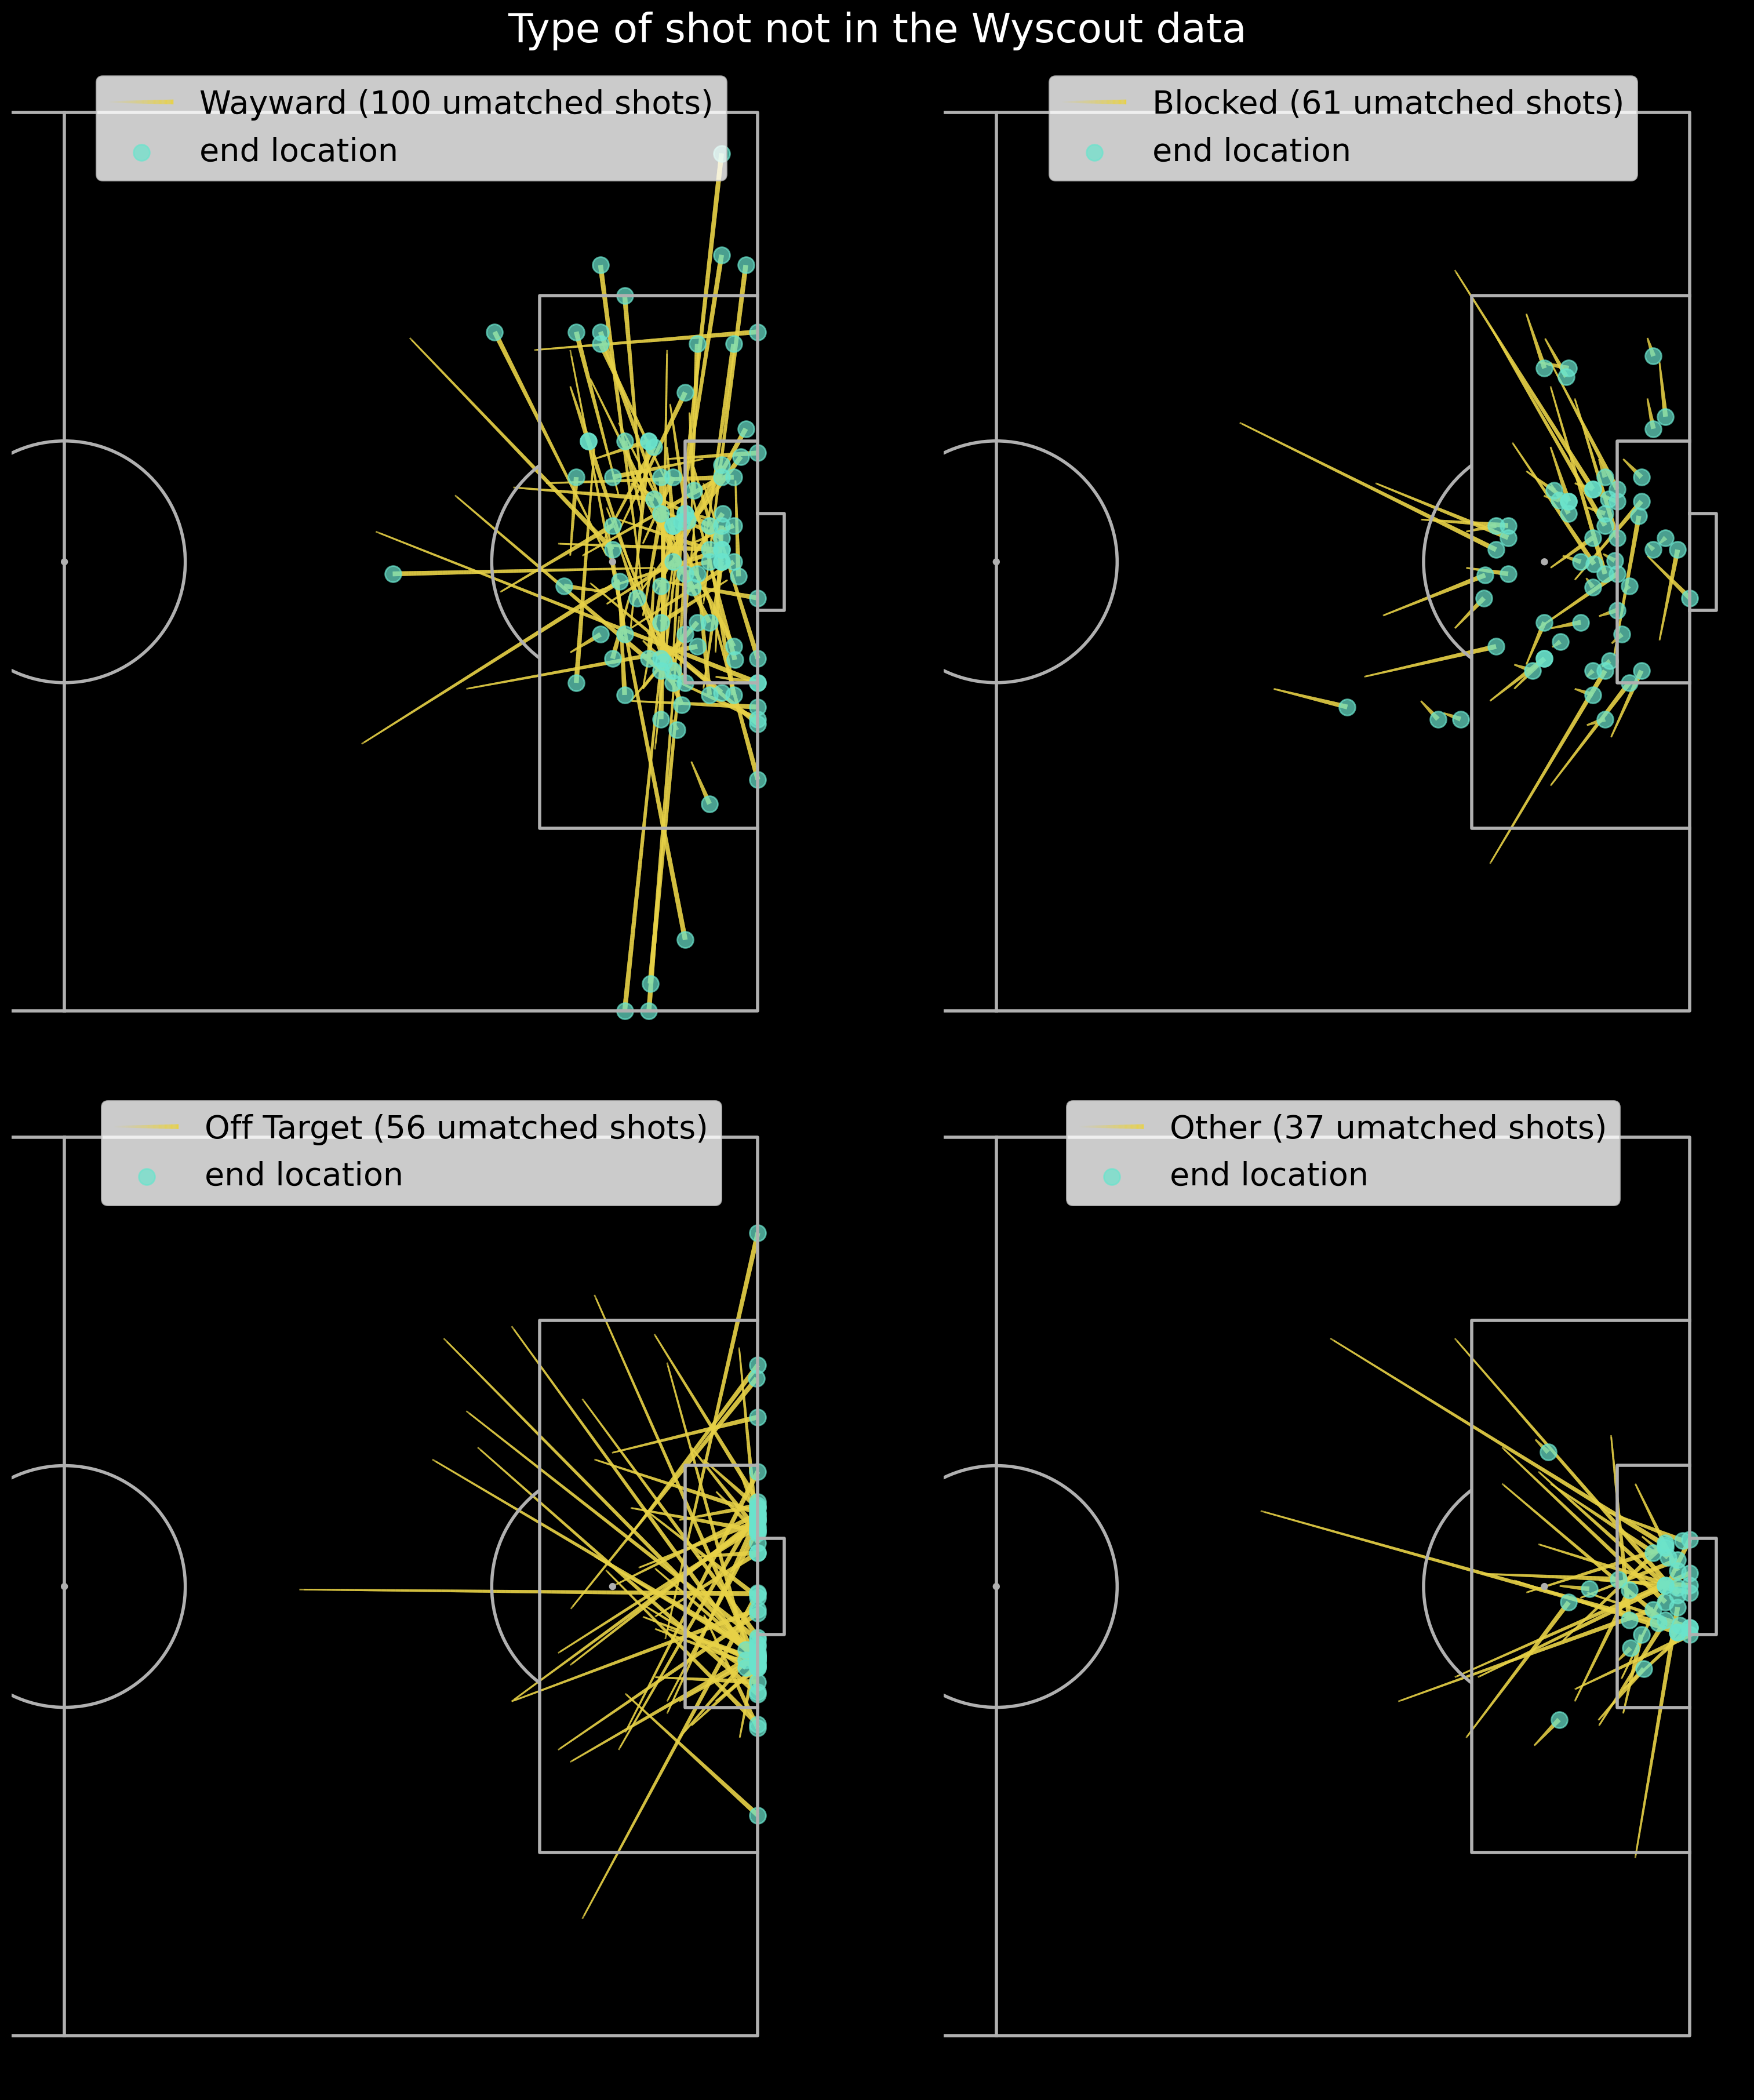

In [45]:
pitch_grid = Pitch(pitch_type='uefa', half=True, pitch_color='black',
                   line_zorder=3, goal_type='box')
fig, ax = pitch_grid.draw(figsize=(16, 18), nrows=2, ncols=2, constrained_layout=True, tight_layout=False)
ax = ax.ravel()
labels = ['Wayward', 'Blocked', 'Off Target', 'Other']
for i, df in enumerate([wayward, blocked, off_target, other]):
    pitch_grid.lines(df.x, df.y, df.end_x, df.end_y, alpha=0.7,
                     ax=ax[i], color='#e8d247', comet=True, transparent=True, lw=3,
                     label=f'{labels[i]} ({len(df)} umatched shots)')
    pitch_grid.scatter(df.end_x, df.end_y, ax=ax[i], s=100, c='#6ae4cd', alpha=0.7,
                       label='end location', zorder=2)
    ax[i].legend(loc='upper center', fontsize=20)
fig.suptitle('Type of shot not in the Wyscout data', fontsize=25, color='white')
fig.set_facecolor('black')
fig.savefig(os.path.join('..', 'figures', '14_overlap_shot_type_unmatched.png'),
            bbox_inches='tight', pad_inches=0.2, facecolor='black')

Average distance between StatsBomb and Wyscout shot locations

In [46]:
distance = ((df_matched_shots.x_statsbomb - df_matched_shots.x_wyscout)**2 +
            (df_matched_shots.y_statsbomb - df_matched_shots.y_wyscout)**2)**0.5

In [47]:
x_diff = df_matched_shots.x_statsbomb - df_matched_shots.x_wyscout
y_diff = df_matched_shots.y_statsbomb - df_matched_shots.y_wyscout

In [48]:
pd.DataFrame({'x_diff': x_diff, 'y_diff': y_diff, 'distance': distance}).describe()

,x_diff,y_diff,distance
count,2346.000000,2346.000000,2346.000000
mean,1.015471,-0.210308,3.367451
std,3.697288,3.063070,3.575422
min,-8.294118,-18.909286,0.064818
25%,-0.461345,-2.028929,1.741253
50%,0.579832,-0.152778,2.826408
75%,2.291667,1.481944,4.263100
max,84.375000,31.917222,86.000068


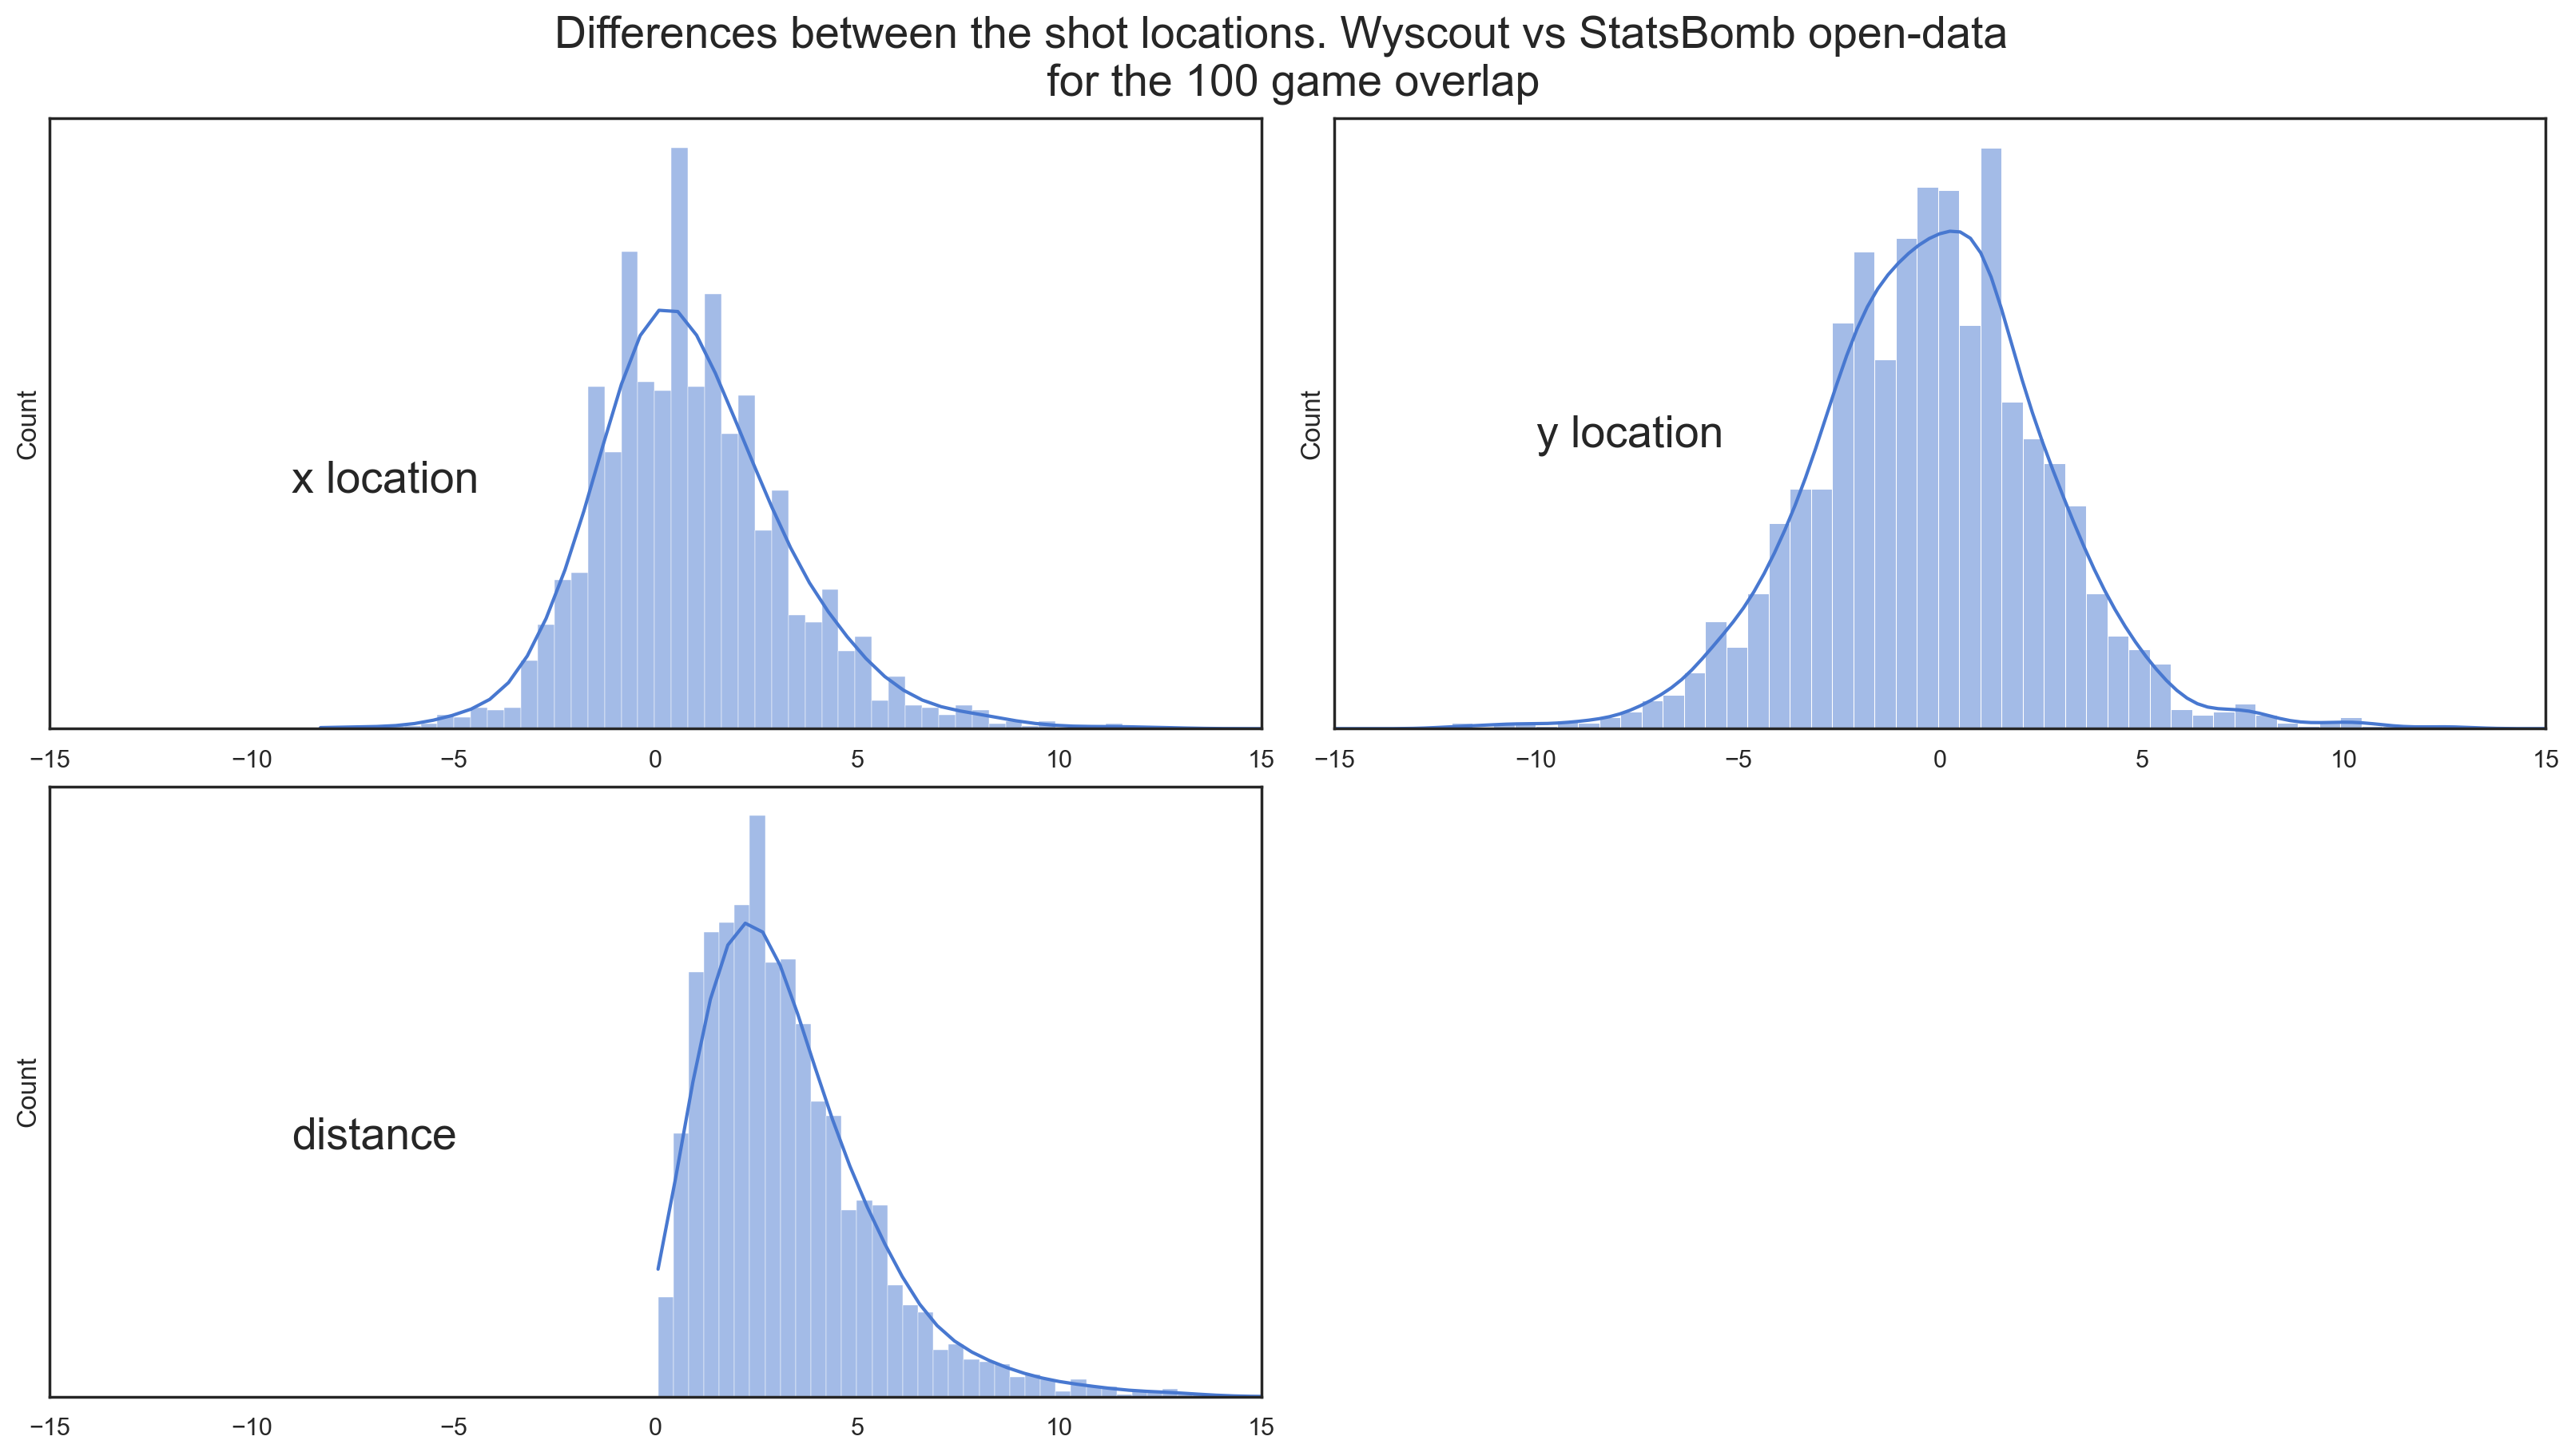

In [49]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set(style="white", palette="muted", color_codes=True)
fig, ax  = plt.subplots(2, 2, figsize=(16, 9), constrained_layout=True)
sns.histplot(x_diff, kde=True, ax=ax[0, 0])
sns.histplot(y_diff, kde=True, ax=ax[0, 1])
sns.histplot(distance, kde=True, ax=ax[1, 0])
plt.setp(ax, yticks=[])
ax[0, 0].set_xlim(-15, 15)
ax[0, 0].annotate('x location', (-9, 100), fontsize=20)
ax[0, 1].set_xlim(-15, 15)
ax[0, 1].annotate('y location', (-10, 100), fontsize=20)
ax[1, 0].set_xlim(-15, 15)
ax[1, 0].annotate('distance', (-9, 100), fontsize=20)
ax[1, 1].remove()
fig.suptitle('Differences between the shot locations. Wyscout vs StatsBomb open-data \n for the 100 game overlap', fontsize=20)
plt.show()
fig.savefig(os.path.join('..', 'figures', '15_overlap_difference_distribution.png'), bbox_inches = 'tight', pad_inches = 0.2)

Plots example match

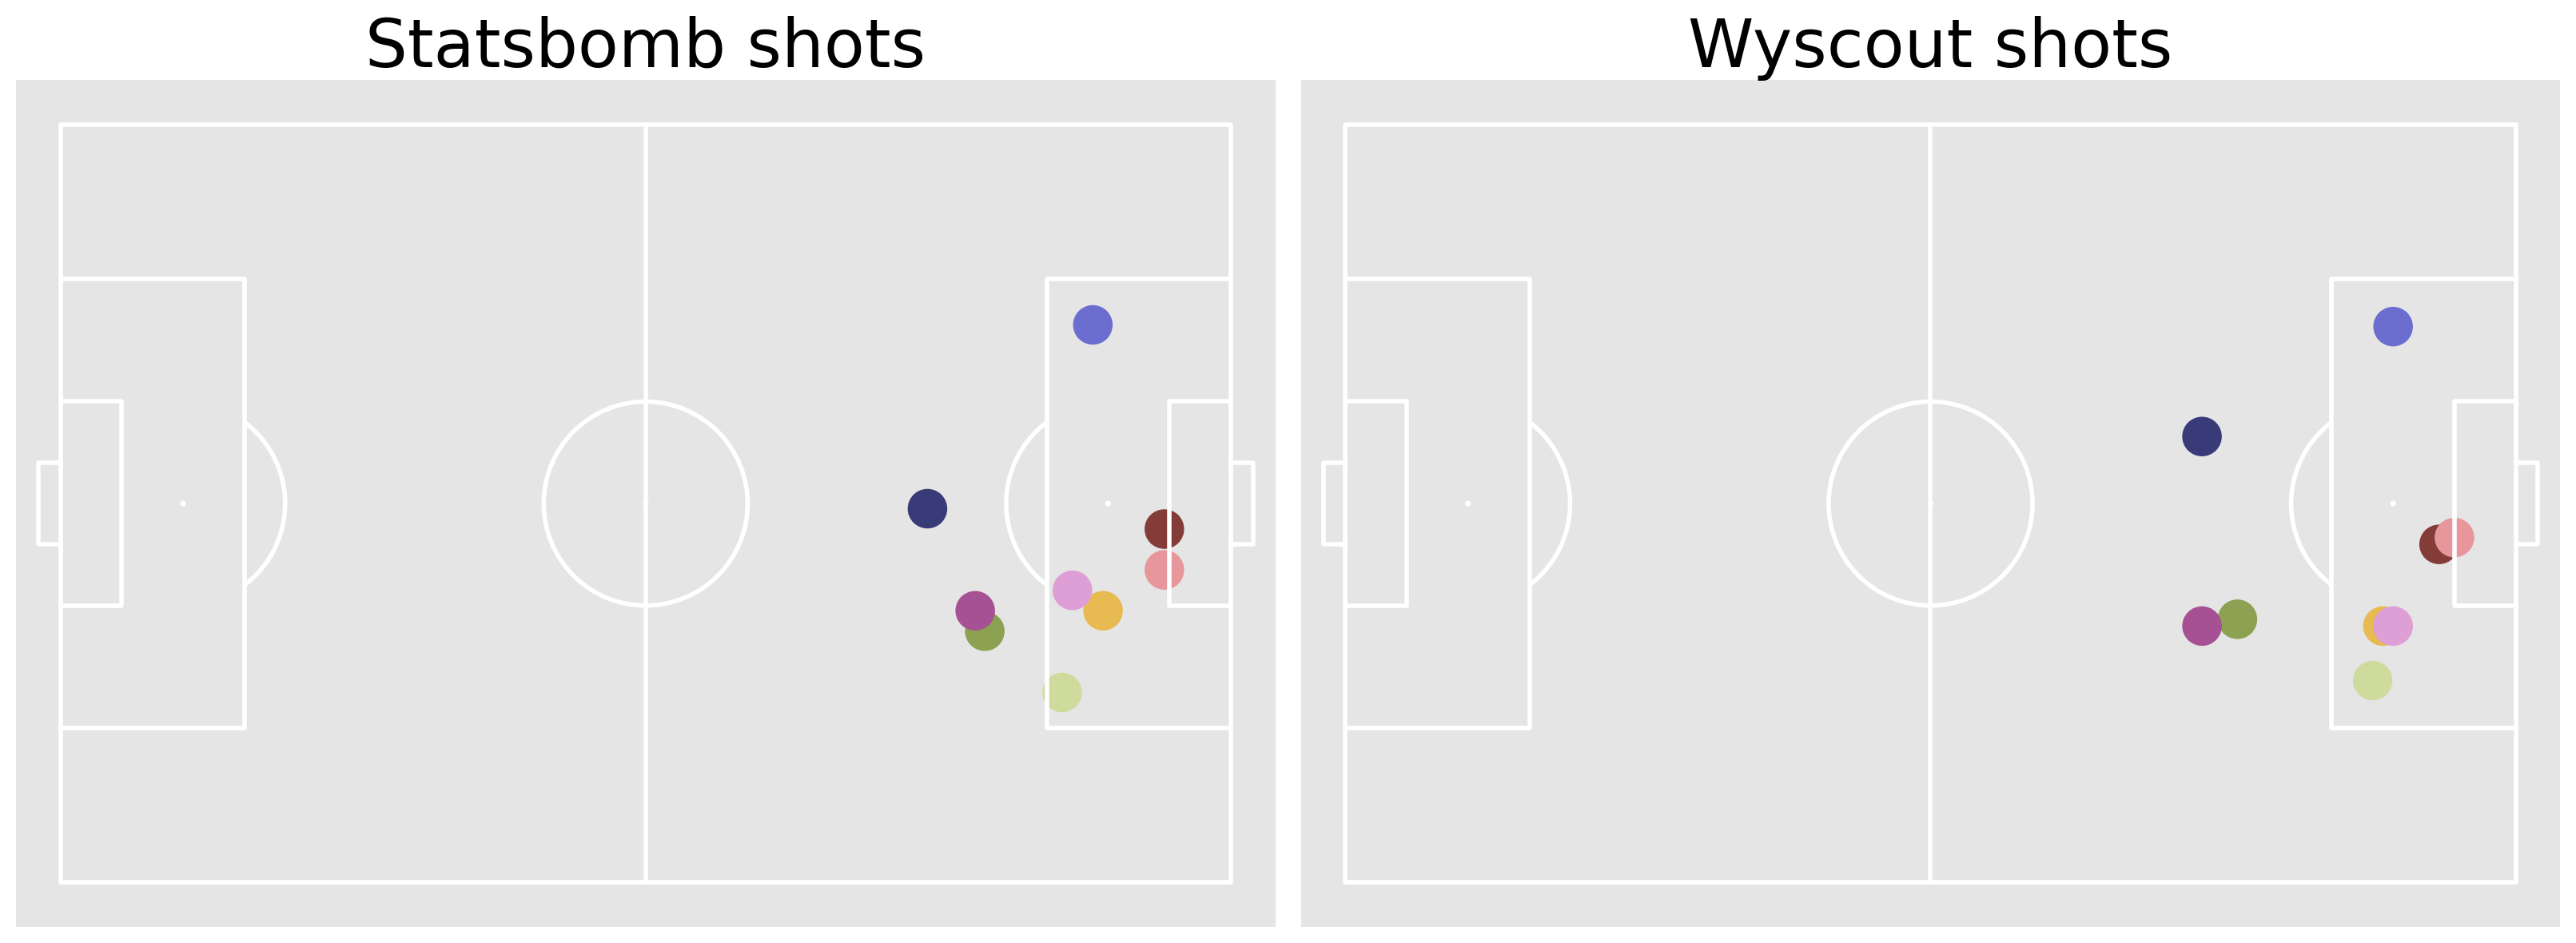

In [50]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('ggplot')
pitch = Pitch(pitch_type='uefa', line_zorder=3, goal_type='box')
all_ids = df_statsbomb_shots.match_id_wyscout.unique()
idx = 1
subset = df_matched_shots[df_matched_shots.match_id_wyscout == all_ids[idx]].copy()
subset_match = df_wyscout_match[df_wyscout_match.match_id == all_ids[idx]]
team1 = subset_match.home_team_name.values[0]
team2 = subset_match.away_team_name.values[0]
fig, ax  = plt.subplots(1, 2, figsize=(16, 9), constrained_layout=True)
pitch.draw(ax=ax[0])
pitch.scatter(subset.x_statsbomb, subset.y_statsbomb, c=np.arange(subset.y_statsbomb.size),
              cmap='tab20b', ax=ax[0], s=300)
ax[0].set_title('Statsbomb shots', fontsize=30, color='black')
pitch.draw(ax=ax[1])
pitch.scatter(subset.x_wyscout, subset.y_wyscout, c=np.arange(subset.y_statsbomb.size),
                           cmap='tab20b', ax=ax[1], s=300)
ax[1].set_title('Wyscout shots', fontsize=30, color='black')
plt.show()
fig.savefig(os.path.join('..', 'figures', '16_overlap_difference_example.png'), bbox_inches = 'tight', pad_inches = 0.2)